The Granite Vision 3.3 model provides experimental support for referring segmentation. The output format of the model is adapted from the [Text4Seg](https://arxiv.org/abs/2410.09855)  with 24x24 patch resolution. 

In [ ]:
import re
import requests
import torch
import torch.nn.functional as F
from PIL import Image
from transformers import AutoProcessor, AutoModelForVision2Seq

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_path = "ibm-granite/granite-vision-3.3-2b"
processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForVision2Seq.from_pretrained(model_path).to(device)

In [6]:
image = Image.open(requests.get("http://farm2.staticflickr.com/1045/934293170_d1b2cc58ff_z.jpg", stream=True).raw)

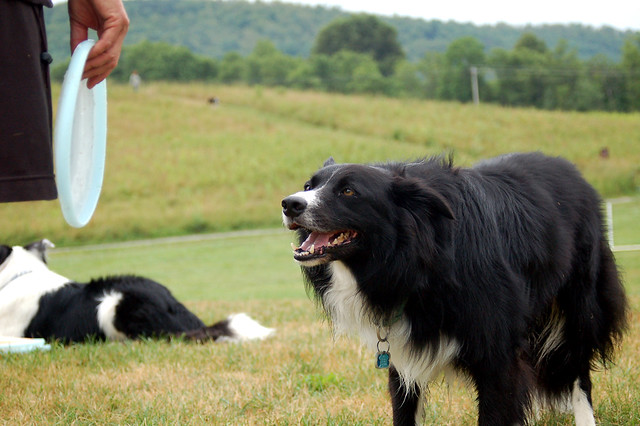

In [7]:
image

We let the model know that we would like to perform segmentation with the task specific prefix "seg: ".

In [8]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "seg: Could you segment the 'dog laying on the left' in the image? Respond with the segmentation mask"},
        ],
    },
]

In [9]:
inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(device)


In [10]:
with torch.autocast(device, dtype=torch.bfloat16), torch.inference_mode():
    output = model.generate(**inputs, max_new_tokens=8192)

In [11]:
decoded_output = processor.decode(output[0], skip_special_tokens=True)

The model will respond with the text ouptut that we will need to translate to binary mask

In [12]:
print(decoded_output)

<|system|>
A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions.
<|user|>

seg: Could you segment the 'dog laying on the left' in the image? Respond with the segmentation mask
<|assistant|>
The segmentation mask for 'dog laying on the left' is shown below:
<seg>others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *24
 others *1| dog laying on the left *1| others *22
 dog laying on the left *2| others *22
 dog laying on the left *3| others *21
 dog laying on the left *6| others *18
 dog laying on the left *7| others *17
 dog laying on the left *10| others *14
 others *24
 others *24
 others *24
 others *24
 others *24
</seg>


In [13]:
def extract_segmentation(
    text: str,
    labels: dict[str, int] | None = None,
    patch_h: int = 24,
    patch_w: int = 24,
) -> list[int] | None:
    """Extracts the segmentation part from a given text."""
    try:
        rows = (
            re.search(r"<seg>(.*?)</seg>", text, re.DOTALL).group(1).strip().split("\n")
        )
    except AttributeError:
        return None
    tokens = [token.split(" *") for row in rows for token in row.split("| ")]
    tokens = [x[0].strip() for x in tokens for _ in range(int(x[1]))]
    if not labels:
        labels = {"others": 0}

    mask = [labels.get(item, 1) for item in tokens]
    total_size = patch_h * patch_w
    if len(mask) < total_size:
        mask = mask + [mask[-1]] * (total_size - len(mask))
    elif len(mask) > total_size:
        mask = mask[:total_size]
    return mask

def prepare_mask(
    mask: list[int], patch_h: int, patch_w: int, size: tuple[int, int]
) -> torch.Tensor:
    mask: torch.Tensor = torch.as_tensor(mask).reshape((patch_h, patch_w))
    mask = mask.gt(0).to(dtype=torch.float32)
    mask = F.interpolate(
        mask[None, None],
        size=(size[1], size[0]),
        mode="nearest",
    ).squeeze()
    return mask


In [14]:
mask = extract_segmentation(decoded_output)
mask = prepare_mask(mask, patch_h=24, patch_w=24, size=image.size)

In [15]:
pil_mask = Image.fromarray((mask.to(torch.uint8) * 255).numpy(), mode="L")

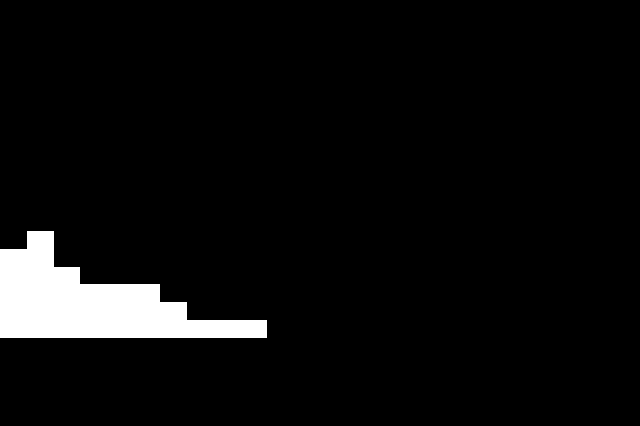

In [28]:
# Let's visualize the mask
pil_mask

In [17]:
def draw_mask(mask: torch.Tensor, image: Image.Image) -> Image.Image:
    m = Image.fromarray(mask.to(torch.bool).numpy())
    red_mask = Image.new("RGBA", image.size, (255, 0, 0, 50))
    red_mask.putalpha(m)
    composite = Image.alpha_composite(image.convert("RGBA"), red_mask)
    return composite

In [18]:
gv_mask = draw_mask(mask, image)

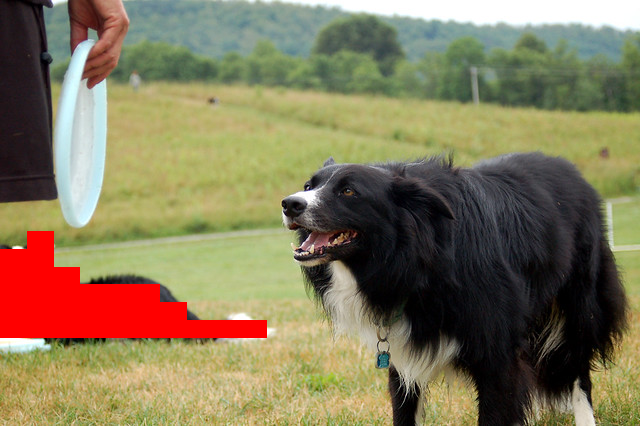

In [19]:
# Let's draw the mask on the image - as previously shown the mask is in the patch format. To make it more smooth we can use refiner as SAM
gv_mask 

In [20]:
def sample_points_from_mask(
    mask: torch.Tensor,
    num_points_to_sample: int,
    is_positive_sample: bool,
) -> torch.Tensor:
    if num_points_to_sample <= 0:
        return torch.empty((0, 2), dtype=torch.long, device=mask.device)

    m_bool = mask.bool()
    h, w = m_bool.shape

    if h == 0 or w == 0:
        return torch.empty((0, 2), dtype=torch.long, device=mask.device)

    target_mask_values = m_bool if is_positive_sample else ~m_bool

    idx_all_flat = torch.arange(h * w, device=m_bool.device)
    target_indices_flat = idx_all_flat[target_mask_values.view(-1)]

    if len(target_indices_flat) == 0:
        return torch.empty((0, 2), dtype=torch.long, device=m_bool.device)

    rand_indices = torch.randint(
        low=0,
        high=len(target_indices_flat),
        size=(num_points_to_sample,),
        device=m_bool.device,
    )
    sampled_flat_indices = target_indices_flat[rand_indices]

    sampled_y = sampled_flat_indices // w
    sampled_x = sampled_flat_indices % w

    xy_coords = torch.stack([sampled_x, sampled_y], dim=1)

    return xy_coords

def sample_points(
    mask: torch.Tensor, num_pos: int = 15, num_neg: int = 10, seed: int | None = None
):

    if mask.ndim != 2:
        raise ValueError(f"Mask must be 2D (H x W), but got shape {mask.shape}")

    if seed is not None:
        torch.manual_seed(seed)

    # Sample positive points
    pos_coords = sample_points_from_mask(
        mask=mask, num_points_to_sample=num_pos, is_positive_sample=True
    )

    # Sample negative points
    neg_coords = sample_points_from_mask(
        mask=mask, num_points_to_sample=num_neg, is_positive_sample=False
    )

    pos_labels = torch.ones(pos_coords.shape[0], dtype=torch.long, device=mask.device)
    neg_labels = torch.zeros(neg_coords.shape[0], dtype=torch.long, device=mask.device)

    points = torch.cat([pos_coords, neg_coords], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)

    return points, labels

def compute_logits_from_mask(
    mask: torch.Tensor,
    eps: float = 1e-3,
    longest_side: int = 256,
) -> torch.Tensor:
    if not isinstance(mask, torch.Tensor):
        mask = torch.as_tensor(mask, dtype=torch.float32)
    mask = mask.to(dtype=torch.float32)

    logits = torch.logit(mask, eps=eps).unsqueeze(0).unsqueeze(0)

    H, W = mask.shape
    scale = longest_side / float(max(H, W))
    new_H = int(round(H * scale))
    new_W = int(round(W * scale))

    logits = F.interpolate(
        logits,
        size=(new_H, new_W),
        mode="bilinear",
        antialias=True,
    )


    pad_h = longest_side - new_H
    pad_w = longest_side - new_W

    logits = F.pad(logits, (0, pad_w, 0, pad_h), mode="constant", value=0.0)
    logits = logits.squeeze(1)

    assert logits.shape == (1, longest_side, longest_side), f"got {logits.shape}"
    return logits


In [21]:
from transformers import SamModel, SamProcessor

In [22]:
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [23]:
# let's first sample points and labels from the mask
input_points, input_labels = sample_points(mask)
# then compute the logits from the mask for SAM input
logits = compute_logits_from_mask(mask)

In [24]:
sam_inputs = sam_processor(
    image,
    input_points=torch.as_tensor(input_points).unsqueeze(0),
    input_labels=torch.as_tensor(input_labels)[None, :],
    return_tensors="pt",
).to(device)
image_positional_embeddings = sam_model.get_image_wide_positional_embeddings()
with torch.autocast(device, torch.bfloat16):
    embeddings = sam_model.get_image_embeddings(sam_inputs["pixel_values"])
    sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
        input_points=sam_inputs["input_points"],
        input_labels=sam_inputs["input_labels"],
        input_masks=logits.to(device),
        input_boxes=None,
    )
    segmentation_maps, _, _ = sam_model.mask_decoder(
        image_embeddings=embeddings,
        image_positional_embeddings=image_positional_embeddings,
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
post_processed_mask = sam_processor.post_process_masks(
    segmentation_maps.cpu(),
    sam_inputs["original_sizes"].cpu(),
    sam_inputs["reshaped_input_sizes"].cpu(),
)

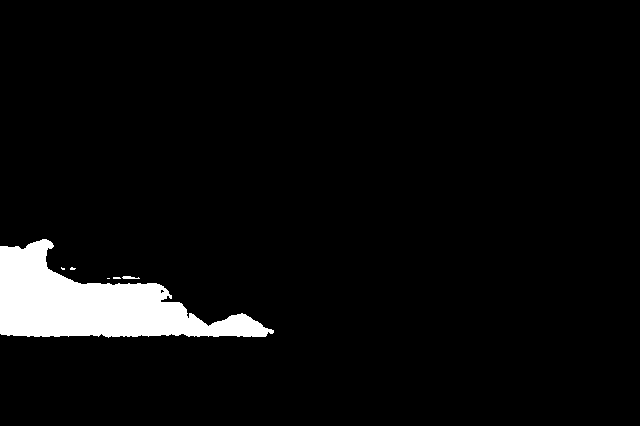

In [25]:
# SAM Made the mask more smooth and look like a dog with minimal artifacts - we could iterate more to make the mask more smooth"
Image.fromarray((post_processed_mask[0].to(torch.uint8).squeeze() * 255).numpy())

In [26]:
sam_mask = draw_mask(post_processed_mask[0].to(torch.uint8).squeeze(), image)

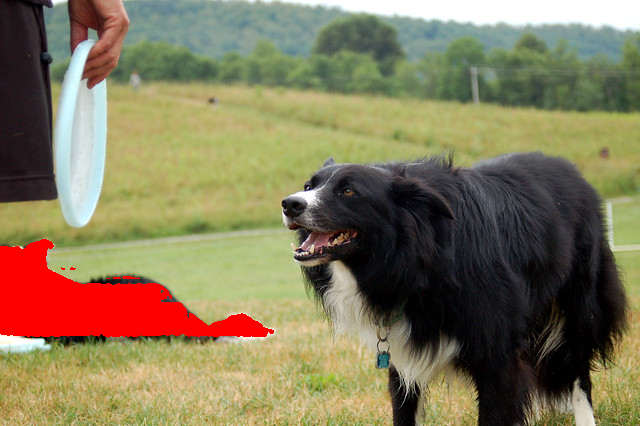

In [27]:
sam_mask